Карпов Андрей (вариант 2)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

In [2]:
def purityCalc(rho):
    '''Calculate purity of state @rho'''
    return np.trace(rho.dot(rho))

#### Генерация случайных квантовых состояний
d = 5, k = 3

$$\rho_{pure} = \rho_A \otimes \rho_B$$
$$\rho_{A} = Tr_B(\rho_{pure})$$

In [3]:
N = 1000
d = 5
k = 3
np.random.seed(500)

eigenvals = np.empty(0) 
for i in range(N):
    
    psi = np.array([np.random.normal(0, 1, d*k) + 1j*np.random.normal(0, 1, d*k)])
    norm = np.sqrt(np.sum(np.abs(psi)**2))
    psi /= norm

    pure_rho = np.outer(psi, psi.conj())
    mixed_rho = np.trace(pure_rho.reshape(d,k,d,k), axis1=1, axis2=3) # trace on subsystem
    
    # calculate eigenvalues
    mixed_rho_eigen = np.linalg.eigvals(mixed_rho)
    eigenvals = np.append(eigenvals, mixed_rho_eigen)

C:\Users\duhak\Python\Python310\lib\site-packages\numpy\lib\histograms.py:852: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
C:\Users\duhak\Python\Python310\lib\site-packages\matplotlib\transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


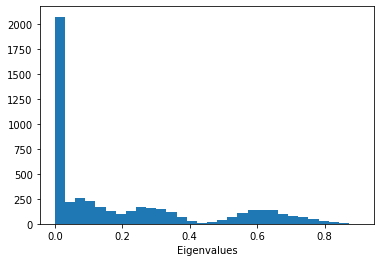

In [4]:
plt.hist(eigenvals, bins=30)
plt.xlabel('Eigenvalues')
plt.show()

In [5]:
%%time
k = np.arange(1,101)
n_aver = 50

purity = []
for k_i in k:
    
    purity_i = 0
    for i in range(n_aver):

        psi = np.array([np.random.normal(0, 1, d*k_i) + 1j*np.random.normal(0, 1, d*k_i)])
        norm = np.sqrt(np.sum(np.abs(psi)**2))
        psi /= norm

        pure_rho = np.outer(psi, psi.conj())
        mixed_rho = np.trace(pure_rho.reshape(d,k_i,d,k_i), axis1=1, axis2=3) # trace on subsystem
        
        purity_i += purityCalc(mixed_rho)
    
    purity_i = purity_i/n_aver
    purity.append(purity_i)

Wall time: 5.36 s


C:\Users\duhak\Python\Python310\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, 'purity')

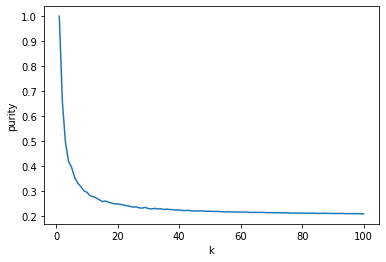

In [6]:
plt.plot(k, purity)
plt.xlabel('k')
plt.ylabel('purity')

#### Разложение Шмидта и процедура очищения

In [43]:
def SchmidtNumberCalc(psi, n, m):
    '''Calculate Schmidt number metric'''
    A = psi.reshape(2**n,2**m)
    B = A.dot(A.T.conj())
    U, S, Vh = np.linalg.svd(B, full_matrices=True)
    
    return 1/(np.sum(S**2))

def negativityCalc(rho, return_eigenvals=False):
    '''Calculate Negativity metric'''
    x = pure_rho.shape[0]//2 # parameter for partial transpose

    rhoTa = pure_rho.copy()
    rhoTa[0:x,x:], rhoTa[x:,0:x] = pure_rho[x:,0:x], pure_rho[0:x,x:]

    rhoTa_eigenvals = np.linalg.eigvals(rhoTa).real
    negativity = 0.5*np.sum(np.abs(rhoTa_eigenvals)-rhoTa_eigenvals)
    
    if (return_eigenvals):
        return negativity, rhoTa_eigenvals
    else:
        return negativity

def basis_state(state='000'):
    '''
    Convers qubit-ket notation state to numpy vector
    @state - string, consisted of '0' or '1' like '001'
    '''
    zero_state = np.array([1,0])
    one_state = np.array([0,1])
    basis_1D = [zero_state, one_state]
    
    for i in range(len(state)):
        if (i==0):
            res = basis_1D[int(state[i])]
            continue
        res = np.kron(res, basis_1D[int(state[i])])
        
    return res

In [31]:
psi =  np.sqrt(11)/8*basis_state('0001') - 3/8*basis_state('0011') + np.sqrt(10)/8*basis_state('0111') + np.sqrt(34)/8*basis_state('1111')
psi

array([ 0.        ,  0.4145781 ,  0.        , -0.375     ,  0.        ,
        0.        ,  0.        ,  0.39528471,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.72886899])

##### Пункт 1. Разложение Шмидта.

In [32]:
# Schmidt's decomposition
A = psi.reshape(4,4)
B = A.dot(A.T.conj())
U, S, Vh = np.linalg.svd(B, full_matrices=True)
U_, S_, Vh_ = np.linalg.svd(A, full_matrices=True)
S

array([8.63092189e-01, 1.36907811e-01, 1.42646465e-17, 0.00000000e+00])

In [33]:
psi_sch = np.zeros_like(psi)
for i in range(4):
    psi_sch += np.sqrt(S[i])*np.kron(U_[:,i], Vh_[i,:])
 
psi_sch.round(7)

array([ 0.       ,  0.4145781,  0.       , -0.375    ,  0.       ,
        0.       ,  0.       ,  0.3952847,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.728869 ])

##### Пункт 2. Матрицы подсистем

In [34]:
# matrices of subsystems
rhoA = np.zeros((4,4))
rhoB = np.zeros((4,4))
for i in range(4):
    rhoA += S[i]*np.outer(U_[:,i], U_[:,i].conj())
    rhoB += S[i]*np.outer(Vh_[i,:], Vh_[i,:].conj())

In [35]:
print('Schmidt method')
print('rho_A \n', rhoA.round(3))
print('rho_B \n', rhoB.round(3))

Schmidt method
rho_A 
 [[ 0.313 -0.148  0.    -0.273]
 [-0.148  0.156  0.     0.288]
 [ 0.     0.     0.     0.   ]
 [-0.273  0.288  0.     0.531]]
rho_B 
 [[ 0.     0.     0.     0.   ]
 [ 0.     0.172  0.    -0.155]
 [ 0.     0.     0.     0.   ]
 [ 0.    -0.155  0.     0.828]]


In [36]:
pure_rho = np.outer(psi, psi.conj())
rhoA_trace = np.trace(pure_rho.reshape(4,4,4,4), axis1=1, axis2=3)
rhoB_trace = np.trace(pure_rho.reshape(4,4,4,4), axis1=0, axis2=2)

In [37]:
print('Trace method')
print('rho_A \n', rhoA_trace.round(3))
print('rho_B \n', rhoB_trace.round(3))

Trace method
rho_A 
 [[ 0.312 -0.148  0.    -0.273]
 [-0.148  0.156  0.     0.288]
 [ 0.     0.     0.     0.   ]
 [-0.273  0.288  0.     0.531]]
rho_B 
 [[ 0.     0.     0.     0.   ]
 [ 0.     0.172  0.    -0.155]
 [ 0.     0.     0.     0.   ]
 [ 0.    -0.155  0.     0.828]]


##### Пункт 3. Число Шмидта.

In [38]:
K = 1/(np.sum(S**2))
K_corr = 16/(16-1)*(1-1/K**2)
print('Число Шмидта:', K)
print('Коэффициент корреляции Шмидта:', K_corr)

Число Шмидта: 1.3094629156010227
Коэффициент корреляции Шмидта: 0.44459228515624966


##### Пункт 4. Negativity.

In [42]:
pure_rho = np.outer(psi, psi.conj())
x = pure_rho.shape[0]//2 # parameter for partial transpose

rhoTa = pure_rho.copy()
rhoTa[0:x,x:], rhoTa[x:,0:x] = pure_rho[x:,0:x], pure_rho[0:x,x:]

rhoTa_eigenvals = np.linalg.eigvals(rhoTa)
negativity = 0.5*np.sum(np.abs(rhoTa_eigenvals)-rhoTa_eigenvals)
print('Negativity', negativity)

Negativity 0.4074501503251655


Как видно коэффициент кореляции Шмидта близок по значению с negativity, что в какой-то мере говорит об их эквивалентности в качестве метрик запутанности

In [40]:
rhoTa_eigenvals

array([-4.07450150e-01,  7.89800578e-01,  4.07450150e-01,  2.10199422e-01,
       -1.16032323e-17,  4.66444869e-17,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

In [41]:
# test of partial transponation
rho_test = np.arange(1,17).reshape(4,4)
x = rho_test.shape[0]//2 # parameter for partial transpose

rhoTa = rho_test.copy()
rhoTa[0:x,x:], rhoTa[x:,0:x] = rho_test[x:,0:x], rho_test[0:x,x:]
print(rho_test)
print(' ')
print(rhoTa)

[[ 1  2  3  4]
 [ 5  6  7  8]
 [ 9 10 11 12]
 [13 14 15 16]]
 
[[ 1  2  9 10]
 [ 5  6 13 14]
 [ 3  4 11 12]
 [ 7  8 15 16]]


##### Пункт 5. Чистое случайное состояние.


In [45]:
N = 100
n = 4
dim = 2**n

K_aver = 0

negativity_aver = 0

for i in range(N):
    psi = np.array([np.random.normal(0, 1, dim) + 1j*np.random.normal(0, 1, dim)])
    norm = np.linalg.norm(psi)
    psi /= norm

    pure_rho = np.outer(psi, psi.conj())

    negativity_aver += negativityCalc(pure_rho)
    K_aver += SchmidtNumberCalc(psi, 2,2)
    
K_aver /= N
negativity_aver /= N

print('Среднее K: ', K_aver)
print('Среднее negativity: ', negativity_aver)

Среднее K:  2.17360653292065
Среднее negativity:  0.45728019313603624


Как видно при усреднении по случайно сгенерированным чистым состояниям обе величины отличны от значений для незапутанных состояний.